# Imports

In [1]:
import os
import random

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

from evaluation import calculate_wer
from visualization import plot_graphs
from data_utils.dataset import prepare_data
from data_utils.utils import read_json
from models.rec_ace import RecACEWrapModel

c:\Users\SharonK\.virtualenvs\DS38-Dev\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Seeds

In [2]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

torch.manual_seed(SEED)

# Data Paths

In [3]:
datasets_dict = {
    # Default
    'Default Train Clean': 'data/default/train_clean.json',
    'Default Train Other': 'data/default/train_other.json',
    'Default Dev Clean': 'data/default/dev_clean.json',
    'Default Dev Other': 'data/default/dev_other.json',
    'Default Test Clean': 'data/default/test_clean.json',
    'Default Test Other': 'data/default/test_other.json',
    # Video
    'Video Train Clean': 'data/video/train_clean.json',
    'Video Train Other': 'data/video/train_other.json',
    'Video Dev Clean': 'data/video/dev_clean.json',
    'Video Dev Other': 'data/video/dev_other.json',
    'Video Test Clean': 'data/video/test_clean.json',
    'Video Test Other': 'data/video/test_other.json', 
}

# Main

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
DEVICE

'cuda'

## Load essentials

In [6]:
debug = False

# Base architecture
t5_type = 't5-small'

# How to quantize the confidence vectors [only required for rec_ac]
bin_size=10

### Tokenizer

In [7]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

## Read Data

In [8]:
train_set = read_json(json_path=datasets_dict['Default Train Clean'])
dev_set = read_json(json_path=datasets_dict['Default Dev Clean'])
test_set = read_json(json_path=datasets_dict['Default Test Clean'])

## Prepare as DataLoader

In [9]:
batch_size = 64
train_loader = prepare_data(data=train_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=True, debug=debug)
dev_loader = prepare_data(data=dev_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=False)
test_loader = prepare_data(data=test_set , tokenizer=tokenizer, batch_size=batch_size, shuffle=False)

- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens


## Training

In [10]:
def training(model, n_epochs, train_data, dev_data, optimizer, criterion):
    """ Training loop for the model

        Args:
            model (nn.Module): Model to train
            n_epochs (int): Number of epochs to train
            train_data (DataLoader): DataLoader with train data
            dev_data (DataLoader): DataLoader with dev data
            optimizer (torch.optim): Optimizer for the model
            criterion (torch.nn): Loss function

        Returns:
            dict: Dictionary with train and dev losses and accuracies
    """

    # metrics placeholder for recording training stats
    metrics = {
        'loss': {
            'train': [],
            'dev':   []
        },
        'wer': {
            'train': [],
            'dev':   []
        }
    }

    print(f'Training model of type: {model.model_type}')
    print('- Scores vector will be ' + ('ignored' if model.model_type == 'original' else 'used'))
    pbar = tqdm(range(n_epochs), position=0)
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch+1}/{n_epochs}")

        train_losses, train_wer = [], []
        dev_losses, dev_wer = [], []

        ### TRAIN
        model.train()

        # Iterating over batches in train data
        pbar_train = tqdm(train_data, desc="Train")
        for batch in pbar_train:

            optimizer.zero_grad()

            X = batch['sentences'].to(DEVICE)
            S = batch['scores'].to(DEVICE)
            y = batch['labels'].to(DEVICE)

            preds = model(input_ids=X, labels=y, scores_ids=S)

            loss = preds.loss
            logits = preds.logits

            reference = tokenizer.batch_decode(y)
            predicted = tokenizer.batch_decode(logits.argmax(dim=-1))
            wer = calculate_wer(reference, predicted)

            train_losses.append(loss.item())
            train_wer.append(wer)

            loss.backward()
            optimizer.step()

        ### Evaluate DEV set
        model.eval()

        # No need for gradients when evaluating
        with torch.no_grad():
            pbar_dev = tqdm(dev_data, desc="Dev")
            for batch in pbar_dev:

                X = batch['sentences'].to(DEVICE)
                S = batch['scores'].to(DEVICE)
                y = batch['labels'].to(DEVICE)

                dev_preds = model(input_ids=X, labels=y, scores_ids=S)

                dev_loss = dev_preds.loss
                dev_logits = dev_preds.logits

                def_reference = tokenizer.batch_decode(y)
                def_predicted = tokenizer.batch_decode(dev_logits.argmax(dim=-1))
                wer = calculate_wer(def_reference, def_predicted)

                # Calculate DEV loss
                dev_losses.append(dev_loss.item())
                dev_wer.append(wer)


        # Collect epoch's avg scores
        metrics['loss']['train'].append(np.mean(train_losses))
        metrics['loss']['dev'].append(np.mean(dev_losses))
        metrics['wer']['train'].append(np.mean(train_wer))
        metrics['wer']['dev'].append(np.mean(dev_wer))

        print(f"\tDone Epoch: {epoch+1}/{n_epochs}, \t Train Loss AVG: {metrics['loss']['train'][-1]:.04}, Dev Loss AVG: {metrics['loss']['dev'][-1]:.04}")
        print(f"\tDone Epoch: {epoch+1}/{n_epochs}, \t Train WER AVG: {metrics['wer']['train'][-1]:.04}, Dev WER AVG: {metrics['wer']['dev'][-1]:.04}")

    return model, metrics

## Model REC-ACE

In [13]:
model = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True)
model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, metrics = training(model=model,
                          n_epochs=3 if debug else 50,
                          train_data=train_loader,
                          dev_data=dev_loader,
                          optimizer=optimizer,
                          criterion=criterion)

Training model of type: rec_ace
- Scores vector will be used


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 1/50, 	 Train Loss AVG: 0.3515, Dev Loss AVG: 0.2855
	Done Epoch: 1/50, 	 Train WER AVG: 0.153, Dev WER AVG: 0.3111


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 2/50, 	 Train Loss AVG: 0.2767, Dev Loss AVG: 0.1378
	Done Epoch: 2/50, 	 Train WER AVG: 0.1252, Dev WER AVG: 0.1585


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 3/50, 	 Train Loss AVG: 0.2534, Dev Loss AVG: 0.1658
	Done Epoch: 3/50, 	 Train WER AVG: 0.1187, Dev WER AVG: 0.1847


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 4/50, 	 Train Loss AVG: 0.2378, Dev Loss AVG: 0.3285
	Done Epoch: 4/50, 	 Train WER AVG: 0.1143, Dev WER AVG: 0.4954


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 5/50, 	 Train Loss AVG: 0.2267, Dev Loss AVG: 0.2965
	Done Epoch: 5/50, 	 Train WER AVG: 0.1112, Dev WER AVG: 0.3744


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 6/50, 	 Train Loss AVG: 0.2175, Dev Loss AVG: 0.1671
	Done Epoch: 6/50, 	 Train WER AVG: 0.1083, Dev WER AVG: 0.2704


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 7/50, 	 Train Loss AVG: 0.21, Dev Loss AVG: 0.6312
	Done Epoch: 7/50, 	 Train WER AVG: 0.1062, Dev WER AVG: 0.6346


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 8/50, 	 Train Loss AVG: 0.2034, Dev Loss AVG: 0.2278
	Done Epoch: 8/50, 	 Train WER AVG: 0.1045, Dev WER AVG: 0.3858


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 9/50, 	 Train Loss AVG: 0.1977, Dev Loss AVG: 0.1381
	Done Epoch: 9/50, 	 Train WER AVG: 0.1027, Dev WER AVG: 0.1694


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 10/50, 	 Train Loss AVG: 0.1924, Dev Loss AVG: 0.1186
	Done Epoch: 10/50, 	 Train WER AVG: 0.1011, Dev WER AVG: 0.1614


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 11/50, 	 Train Loss AVG: 0.1878, Dev Loss AVG: 0.0954
	Done Epoch: 11/50, 	 Train WER AVG: 0.09987, Dev WER AVG: 0.1105


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 12/50, 	 Train Loss AVG: 0.1834, Dev Loss AVG: 0.14
	Done Epoch: 12/50, 	 Train WER AVG: 0.09843, Dev WER AVG: 0.1971


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 13/50, 	 Train Loss AVG: 0.1794, Dev Loss AVG: 0.119
	Done Epoch: 13/50, 	 Train WER AVG: 0.0972, Dev WER AVG: 0.154


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 14/50, 	 Train Loss AVG: 0.1758, Dev Loss AVG: 0.0964
	Done Epoch: 14/50, 	 Train WER AVG: 0.09599, Dev WER AVG: 0.1032


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 15/50, 	 Train Loss AVG: 0.1723, Dev Loss AVG: 0.1318
	Done Epoch: 15/50, 	 Train WER AVG: 0.09514, Dev WER AVG: 0.2106


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 16/50, 	 Train Loss AVG: 0.1692, Dev Loss AVG: 0.171
	Done Epoch: 16/50, 	 Train WER AVG: 0.09419, Dev WER AVG: 0.2777


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 17/50, 	 Train Loss AVG: 0.1661, Dev Loss AVG: 0.09895
	Done Epoch: 17/50, 	 Train WER AVG: 0.0931, Dev WER AVG: 0.1248


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 18/50, 	 Train Loss AVG: 0.1631, Dev Loss AVG: 0.1126
	Done Epoch: 18/50, 	 Train WER AVG: 0.09212, Dev WER AVG: 0.1622


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 19/50, 	 Train Loss AVG: 0.1603, Dev Loss AVG: 0.1407
	Done Epoch: 19/50, 	 Train WER AVG: 0.0913, Dev WER AVG: 0.2132


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 20/50, 	 Train Loss AVG: 0.1577, Dev Loss AVG: 0.1087
	Done Epoch: 20/50, 	 Train WER AVG: 0.09052, Dev WER AVG: 0.1504


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 21/50, 	 Train Loss AVG: 0.1552, Dev Loss AVG: 0.1404
	Done Epoch: 21/50, 	 Train WER AVG: 0.08982, Dev WER AVG: 0.2197


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 22/50, 	 Train Loss AVG: 0.1528, Dev Loss AVG: 0.1018
	Done Epoch: 22/50, 	 Train WER AVG: 0.08889, Dev WER AVG: 0.1435


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 23/50, 	 Train Loss AVG: 0.1504, Dev Loss AVG: 0.1377
	Done Epoch: 23/50, 	 Train WER AVG: 0.08794, Dev WER AVG: 0.2311


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 24/50, 	 Train Loss AVG: 0.1482, Dev Loss AVG: 0.163
	Done Epoch: 24/50, 	 Train WER AVG: 0.08744, Dev WER AVG: 0.2803


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 25/50, 	 Train Loss AVG: 0.1462, Dev Loss AVG: 0.09896
	Done Epoch: 25/50, 	 Train WER AVG: 0.08686, Dev WER AVG: 0.1334


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 26/50, 	 Train Loss AVG: 0.1441, Dev Loss AVG: 0.1074
	Done Epoch: 26/50, 	 Train WER AVG: 0.08592, Dev WER AVG: 0.16


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 27/50, 	 Train Loss AVG: 0.142, Dev Loss AVG: 0.105
	Done Epoch: 27/50, 	 Train WER AVG: 0.08546, Dev WER AVG: 0.1598


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 28/50, 	 Train Loss AVG: 0.14, Dev Loss AVG: 0.08712
	Done Epoch: 28/50, 	 Train WER AVG: 0.08473, Dev WER AVG: 0.09533


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 29/50, 	 Train Loss AVG: 0.1383, Dev Loss AVG: 0.08877
	Done Epoch: 29/50, 	 Train WER AVG: 0.08414, Dev WER AVG: 0.1017


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 30/50, 	 Train Loss AVG: 0.1364, Dev Loss AVG: 0.08999
	Done Epoch: 30/50, 	 Train WER AVG: 0.08349, Dev WER AVG: 0.1034


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 31/50, 	 Train Loss AVG: 0.1347, Dev Loss AVG: 0.1008
	Done Epoch: 31/50, 	 Train WER AVG: 0.08279, Dev WER AVG: 0.1394


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 32/50, 	 Train Loss AVG: 0.1329, Dev Loss AVG: 0.1125
	Done Epoch: 32/50, 	 Train WER AVG: 0.08229, Dev WER AVG: 0.1582


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 33/50, 	 Train Loss AVG: 0.1314, Dev Loss AVG: 0.09701
	Done Epoch: 33/50, 	 Train WER AVG: 0.08172, Dev WER AVG: 0.1335


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 34/50, 	 Train Loss AVG: 0.1296, Dev Loss AVG: 0.1005
	Done Epoch: 34/50, 	 Train WER AVG: 0.08096, Dev WER AVG: 0.1401


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 35/50, 	 Train Loss AVG: 0.128, Dev Loss AVG: 0.1262
	Done Epoch: 35/50, 	 Train WER AVG: 0.08041, Dev WER AVG: 0.2119


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 36/50, 	 Train Loss AVG: 0.1265, Dev Loss AVG: 0.1236
	Done Epoch: 36/50, 	 Train WER AVG: 0.07992, Dev WER AVG: 0.2076


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 37/50, 	 Train Loss AVG: 0.125, Dev Loss AVG: 0.1446
	Done Epoch: 37/50, 	 Train WER AVG: 0.07943, Dev WER AVG: 0.2444


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 38/50, 	 Train Loss AVG: 0.1235, Dev Loss AVG: 0.1093
	Done Epoch: 38/50, 	 Train WER AVG: 0.07907, Dev WER AVG: 0.1751


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 39/50, 	 Train Loss AVG: 0.122, Dev Loss AVG: 0.1039
	Done Epoch: 39/50, 	 Train WER AVG: 0.07844, Dev WER AVG: 0.157


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 40/50, 	 Train Loss AVG: 0.1206, Dev Loss AVG: 0.1112
	Done Epoch: 40/50, 	 Train WER AVG: 0.0778, Dev WER AVG: 0.1832


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 41/50, 	 Train Loss AVG: 0.1193, Dev Loss AVG: 0.1135
	Done Epoch: 41/50, 	 Train WER AVG: 0.07731, Dev WER AVG: 0.1858


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 42/50, 	 Train Loss AVG: 0.1177, Dev Loss AVG: 0.1079
	Done Epoch: 42/50, 	 Train WER AVG: 0.07677, Dev WER AVG: 0.1649


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 43/50, 	 Train Loss AVG: 0.1165, Dev Loss AVG: 0.1055
	Done Epoch: 43/50, 	 Train WER AVG: 0.07633, Dev WER AVG: 0.1581


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 44/50, 	 Train Loss AVG: 0.1151, Dev Loss AVG: 0.127
	Done Epoch: 44/50, 	 Train WER AVG: 0.07579, Dev WER AVG: 0.2172


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 45/50, 	 Train Loss AVG: 0.1138, Dev Loss AVG: 0.08692
	Done Epoch: 45/50, 	 Train WER AVG: 0.07534, Dev WER AVG: 0.09259


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 46/50, 	 Train Loss AVG: 0.1125, Dev Loss AVG: 0.08785
	Done Epoch: 46/50, 	 Train WER AVG: 0.07469, Dev WER AVG: 0.09309


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 47/50, 	 Train Loss AVG: 0.1115, Dev Loss AVG: 0.08838
	Done Epoch: 47/50, 	 Train WER AVG: 0.07443, Dev WER AVG: 0.09903


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 48/50, 	 Train Loss AVG: 0.1103, Dev Loss AVG: 0.0905
	Done Epoch: 48/50, 	 Train WER AVG: 0.07386, Dev WER AVG: 0.1043


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 49/50, 	 Train Loss AVG: 0.109, Dev Loss AVG: 0.09209
	Done Epoch: 49/50, 	 Train WER AVG: 0.07339, Dev WER AVG: 0.1113


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 50/50, 	 Train Loss AVG: 0.1077, Dev Loss AVG: 0.09609
	Done Epoch: 50/50, 	 Train WER AVG: 0.07288, Dev WER AVG: 0.1313


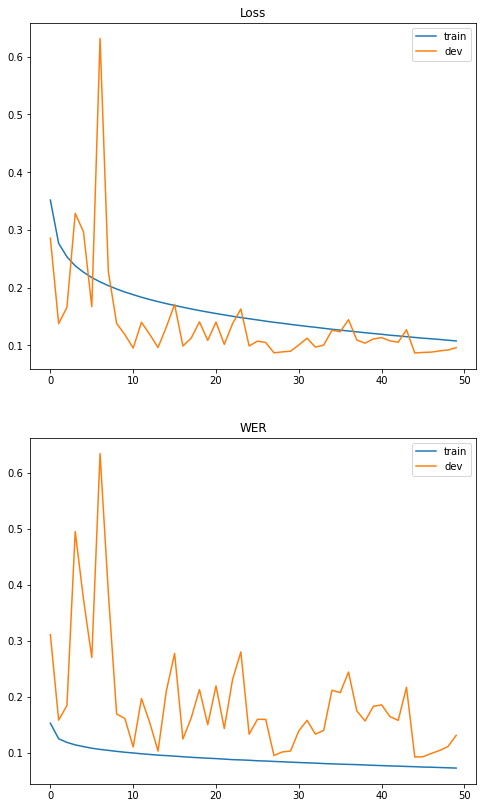

In [16]:
plot_graphs(metrics)

## Model Original T5

In [11]:
orig_model = RecACEWrapModel(t5_type=t5_type, model_type='original', bin_size=bin_size, use_pretrained=True)
orig_model.to(DEVICE)

orig_criterion = torch.nn.CrossEntropyLoss()
orig_optimizer = torch.optim.Adam(orig_model.parameters(), lr=1e-4)

orig_model, orig_metrics = training(model=orig_model,
                          n_epochs=3 if debug else 50,
                          train_data=train_loader,
                          dev_data=dev_loader,
                          optimizer=orig_optimizer,
                          criterion=orig_criterion)

Training model of type: original
- Scores vector will be ignored


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 1/50, 	 Train Loss AVG: 0.3521, Dev Loss AVG: 0.2588
	Done Epoch: 1/50, 	 Train WER AVG: 0.1539, Dev WER AVG: 0.2886


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 2/50, 	 Train Loss AVG: 0.2788, Dev Loss AVG: 0.1381
	Done Epoch: 2/50, 	 Train WER AVG: 0.1256, Dev WER AVG: 0.1384


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 3/50, 	 Train Loss AVG: 0.2579, Dev Loss AVG: 0.1243
	Done Epoch: 3/50, 	 Train WER AVG: 0.1197, Dev WER AVG: 0.1492


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 4/50, 	 Train Loss AVG: 0.2439, Dev Loss AVG: 0.1426
	Done Epoch: 4/50, 	 Train WER AVG: 0.1154, Dev WER AVG: 0.1669


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 5/50, 	 Train Loss AVG: 0.2327, Dev Loss AVG: 0.1341
	Done Epoch: 5/50, 	 Train WER AVG: 0.1124, Dev WER AVG: 0.1445


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 6/50, 	 Train Loss AVG: 0.2239, Dev Loss AVG: 0.2483
	Done Epoch: 6/50, 	 Train WER AVG: 0.1099, Dev WER AVG: 0.4209


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 7/50, 	 Train Loss AVG: 0.2165, Dev Loss AVG: 0.2967
	Done Epoch: 7/50, 	 Train WER AVG: 0.1078, Dev WER AVG: 0.4741


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 8/50, 	 Train Loss AVG: 0.2101, Dev Loss AVG: 0.1195
	Done Epoch: 8/50, 	 Train WER AVG: 0.1061, Dev WER AVG: 0.1809


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 9/50, 	 Train Loss AVG: 0.2042, Dev Loss AVG: 0.1649
	Done Epoch: 9/50, 	 Train WER AVG: 0.1043, Dev WER AVG: 0.2961


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 10/50, 	 Train Loss AVG: 0.199, Dev Loss AVG: 0.1157
	Done Epoch: 10/50, 	 Train WER AVG: 0.1029, Dev WER AVG: 0.152


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 11/50, 	 Train Loss AVG: 0.1942, Dev Loss AVG: 0.1165
	Done Epoch: 11/50, 	 Train WER AVG: 0.1016, Dev WER AVG: 0.1579


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 12/50, 	 Train Loss AVG: 0.19, Dev Loss AVG: 0.1404
	Done Epoch: 12/50, 	 Train WER AVG: 0.1001, Dev WER AVG: 0.2054


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 13/50, 	 Train Loss AVG: 0.186, Dev Loss AVG: 0.1033
	Done Epoch: 13/50, 	 Train WER AVG: 0.09901, Dev WER AVG: 0.1335


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 14/50, 	 Train Loss AVG: 0.1823, Dev Loss AVG: 0.1223
	Done Epoch: 14/50, 	 Train WER AVG: 0.09794, Dev WER AVG: 0.1895


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 15/50, 	 Train Loss AVG: 0.1788, Dev Loss AVG: 0.09938
	Done Epoch: 15/50, 	 Train WER AVG: 0.09684, Dev WER AVG: 0.1193


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 16/50, 	 Train Loss AVG: 0.1756, Dev Loss AVG: 0.1023
	Done Epoch: 16/50, 	 Train WER AVG: 0.09585, Dev WER AVG: 0.1397


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 17/50, 	 Train Loss AVG: 0.1725, Dev Loss AVG: 0.1171
	Done Epoch: 17/50, 	 Train WER AVG: 0.09504, Dev WER AVG: 0.1851


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 18/50, 	 Train Loss AVG: 0.1695, Dev Loss AVG: 0.1022
	Done Epoch: 18/50, 	 Train WER AVG: 0.09424, Dev WER AVG: 0.1351


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 19/50, 	 Train Loss AVG: 0.1669, Dev Loss AVG: 0.1248
	Done Epoch: 19/50, 	 Train WER AVG: 0.09345, Dev WER AVG: 0.2042


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 20/50, 	 Train Loss AVG: 0.164, Dev Loss AVG: 0.1041
	Done Epoch: 20/50, 	 Train WER AVG: 0.09243, Dev WER AVG: 0.152


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 21/50, 	 Train Loss AVG: 0.1616, Dev Loss AVG: 0.1023
	Done Epoch: 21/50, 	 Train WER AVG: 0.09193, Dev WER AVG: 0.1469


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 22/50, 	 Train Loss AVG: 0.1592, Dev Loss AVG: 0.09095
	Done Epoch: 22/50, 	 Train WER AVG: 0.09112, Dev WER AVG: 0.09779


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 23/50, 	 Train Loss AVG: 0.1568, Dev Loss AVG: 0.09589
	Done Epoch: 23/50, 	 Train WER AVG: 0.09033, Dev WER AVG: 0.1177


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 24/50, 	 Train Loss AVG: 0.1547, Dev Loss AVG: 0.09621
	Done Epoch: 24/50, 	 Train WER AVG: 0.08941, Dev WER AVG: 0.1215


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 25/50, 	 Train Loss AVG: 0.1524, Dev Loss AVG: 0.09818
	Done Epoch: 25/50, 	 Train WER AVG: 0.08881, Dev WER AVG: 0.1292


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 26/50, 	 Train Loss AVG: 0.1502, Dev Loss AVG: 0.1317
	Done Epoch: 26/50, 	 Train WER AVG: 0.08822, Dev WER AVG: 0.2228


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 27/50, 	 Train Loss AVG: 0.1483, Dev Loss AVG: 0.108
	Done Epoch: 27/50, 	 Train WER AVG: 0.08753, Dev WER AVG: 0.1698


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 28/50, 	 Train Loss AVG: 0.1464, Dev Loss AVG: 0.1017
	Done Epoch: 28/50, 	 Train WER AVG: 0.08707, Dev WER AVG: 0.1551


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 29/50, 	 Train Loss AVG: 0.1442, Dev Loss AVG: 0.1155
	Done Epoch: 29/50, 	 Train WER AVG: 0.08627, Dev WER AVG: 0.192


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 30/50, 	 Train Loss AVG: 0.1425, Dev Loss AVG: 0.1381
	Done Epoch: 30/50, 	 Train WER AVG: 0.08572, Dev WER AVG: 0.2447


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 31/50, 	 Train Loss AVG: 0.1408, Dev Loss AVG: 0.1265
	Done Epoch: 31/50, 	 Train WER AVG: 0.08515, Dev WER AVG: 0.2147


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 32/50, 	 Train Loss AVG: 0.139, Dev Loss AVG: 0.131
	Done Epoch: 32/50, 	 Train WER AVG: 0.08462, Dev WER AVG: 0.2252


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 33/50, 	 Train Loss AVG: 0.1372, Dev Loss AVG: 0.1392
	Done Epoch: 33/50, 	 Train WER AVG: 0.08396, Dev WER AVG: 0.2459


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 34/50, 	 Train Loss AVG: 0.1356, Dev Loss AVG: 0.1284
	Done Epoch: 34/50, 	 Train WER AVG: 0.08332, Dev WER AVG: 0.2253


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 35/50, 	 Train Loss AVG: 0.134, Dev Loss AVG: 0.1107
	Done Epoch: 35/50, 	 Train WER AVG: 0.08302, Dev WER AVG: 0.1751


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 36/50, 	 Train Loss AVG: 0.1324, Dev Loss AVG: 0.1301
	Done Epoch: 36/50, 	 Train WER AVG: 0.08253, Dev WER AVG: 0.2322


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 37/50, 	 Train Loss AVG: 0.1309, Dev Loss AVG: 0.1409
	Done Epoch: 37/50, 	 Train WER AVG: 0.08196, Dev WER AVG: 0.253


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 38/50, 	 Train Loss AVG: 0.1292, Dev Loss AVG: 0.0919
	Done Epoch: 38/50, 	 Train WER AVG: 0.08122, Dev WER AVG: 0.1078


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 39/50, 	 Train Loss AVG: 0.1279, Dev Loss AVG: 0.09502
	Done Epoch: 39/50, 	 Train WER AVG: 0.08087, Dev WER AVG: 0.1297


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 40/50, 	 Train Loss AVG: 0.1263, Dev Loss AVG: 0.09956
	Done Epoch: 40/50, 	 Train WER AVG: 0.08041, Dev WER AVG: 0.1494


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 41/50, 	 Train Loss AVG: 0.125, Dev Loss AVG: 0.1009
	Done Epoch: 41/50, 	 Train WER AVG: 0.07966, Dev WER AVG: 0.1484


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 42/50, 	 Train Loss AVG: 0.1235, Dev Loss AVG: 0.1111
	Done Epoch: 42/50, 	 Train WER AVG: 0.07912, Dev WER AVG: 0.1843


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 43/50, 	 Train Loss AVG: 0.1223, Dev Loss AVG: 0.1384
	Done Epoch: 43/50, 	 Train WER AVG: 0.07891, Dev WER AVG: 0.2531


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 44/50, 	 Train Loss AVG: 0.121, Dev Loss AVG: 0.1295
	Done Epoch: 44/50, 	 Train WER AVG: 0.07834, Dev WER AVG: 0.2363


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 45/50, 	 Train Loss AVG: 0.1195, Dev Loss AVG: 0.1061
	Done Epoch: 45/50, 	 Train WER AVG: 0.07789, Dev WER AVG: 0.1697


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 46/50, 	 Train Loss AVG: 0.1184, Dev Loss AVG: 0.09773
	Done Epoch: 46/50, 	 Train WER AVG: 0.07739, Dev WER AVG: 0.136


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 47/50, 	 Train Loss AVG: 0.117, Dev Loss AVG: 0.1168
	Done Epoch: 47/50, 	 Train WER AVG: 0.07692, Dev WER AVG: 0.198


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 48/50, 	 Train Loss AVG: 0.1158, Dev Loss AVG: 0.1093
	Done Epoch: 48/50, 	 Train WER AVG: 0.0765, Dev WER AVG: 0.1687


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 49/50, 	 Train Loss AVG: 0.1145, Dev Loss AVG: 0.1232
	Done Epoch: 49/50, 	 Train WER AVG: 0.07601, Dev WER AVG: 0.2022


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 50/50, 	 Train Loss AVG: 0.1134, Dev Loss AVG: 0.1287
	Done Epoch: 50/50, 	 Train WER AVG: 0.07556, Dev WER AVG: 0.2139


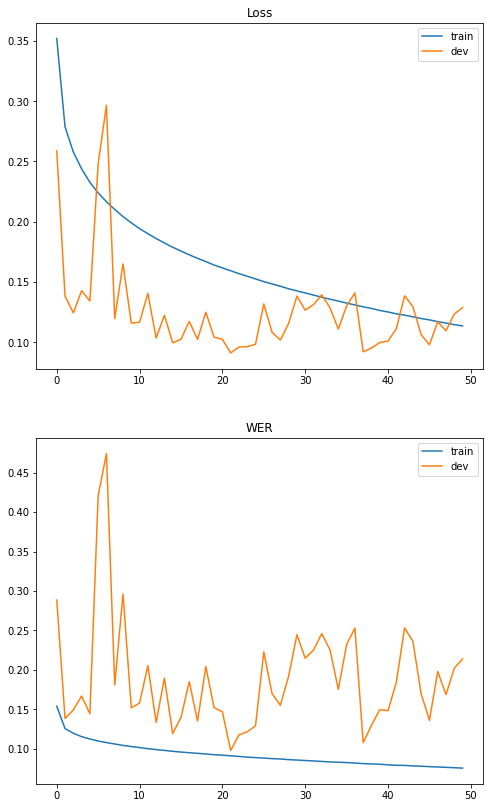

In [12]:
plot_graphs(orig_metrics)

## Experiments

1. Training the following models:
    1. Calculate WER on Dev on 'Clean' and 'Other'
    1. T5 w/o confidence on 'Clean'
    1. T5 w/ confidence on 'Clean'
    1. T5 w/o confidence on 'Other'
    1. T5 w/ confidence on 'Other'
    *. T5 (large) w/ confidence on 'Clean'
    *. T5 (large) w/o confidence on 'Clean'
    *. Prompt Engineering w/ confidence on 'Clean'
    *. Prompt Engineering w/o confidence on 'Clean'

1. Evaluate performance on Test Dataset
    1. Calculate WER on Test set on 'Clean' and 'Other'
    1. for every BEST model above calculate WER on 'Clean' and 'Other'